_Note: This is still work in progress_

TODO I should normalize $x$, not $A$ by $1/N$

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as pl
import cvxpy as cvx
import itertools as it

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import sys
sys.path.append('/Users/dsuess/Code/Pythonlibs/')
# see https://github.com/dseuss/pythonlibs
from tools.helpers import Progress

In [2]:
def random_sparse_vector(dim, nnz, rgen=np.random):
    """Create a random sparse vector of dimension `dim` 
    with `nnz` nonzero elements """
    idx = rgen.choice(np.arange(dim), size=nnz, replace=False)
    result = np.zeros(dim)
    result[idx] = rgen.randn(nnz)
    return result

def compress(x, r):
    """Computes the best r-sparse approximation to `x` in place"""
    argpart = np.argpartition(np.abs(x), -r)
    support, rest = argpart[-r:], argpart[:-r]
    x[rest] = 0
    return support

def compression(x, r, retsupp=False):
    """Returns the best r-sparse approximation to `x`. If 
    `retsupp` we also return the support of this compression"""
    x_new = x.copy()
    supp = compress(x_new, r)
    return x_new, supp if retsupp else x_new

def sensingmat_gauss(m, n, rgen=np.random):
    """Returns a m*n sensing matrix with independent, normal
    components. See the remark below for normalization"""
    return rgen.randn(m, n) / np.sqrt(m * n)

The normalization of the sensing matrices $A$ is choosen in such a way that $\mathbb{E}\Vert A \Vert_2 = 1$ is independent of $m$ and $n$.
This allows us to normalize $A$ later to $\Vert A \Vert_2 < 1$ with high probability.
The latter condition is important for the convergence of the constant step-size IHT algorithm.
For the other approaches (convex programming or adaptive IHT), the normalization does not matter.

## Convex Programming 

The first question we will check is: "How many measurements do we need to recover the signal?".
For this purpose we will use _basis pursuit denoising_ (the $\ell_1$-regularized least square estimator), which is very efficient in the number of samples.
On the other hand it does not scale well for large systems, due to the higher order polynomial scaling of the corresponding Second order cone program.

In [3]:
def recover(x, m, eta=1.0, sigma=0.0, rgen=np.random):
    A = sensingmat_gauss(m, len(x), rgen)
    y = np.dot(A, x) + sigma / np.sqrt(len(x)) * rgen.randn(m)
    
    x_hat = cvx.Variable(len(x))
    objective = cvx.Minimize(cvx.norm(A * x_hat - y, 2)**2 + eta * cvx.norm(x_hat, 1))
    problem = cvx.Problem(objective, [])
    problem.solve()
    
    return np.ravel(x_hat.value)

def check(signal, sigma, rgen=np.random):
     return np.frompyfunc(lambda m, eta: np.linalg.norm(signal - recover(signal, m, eta, sigma, rgen)),
                          2, 1)

/Users/dsuess/Library/Miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/dsuess/Library/Miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
 95% (19 of 20) |#######################  | Elapsed Time: 0:02:07 ETA:  0:00:06

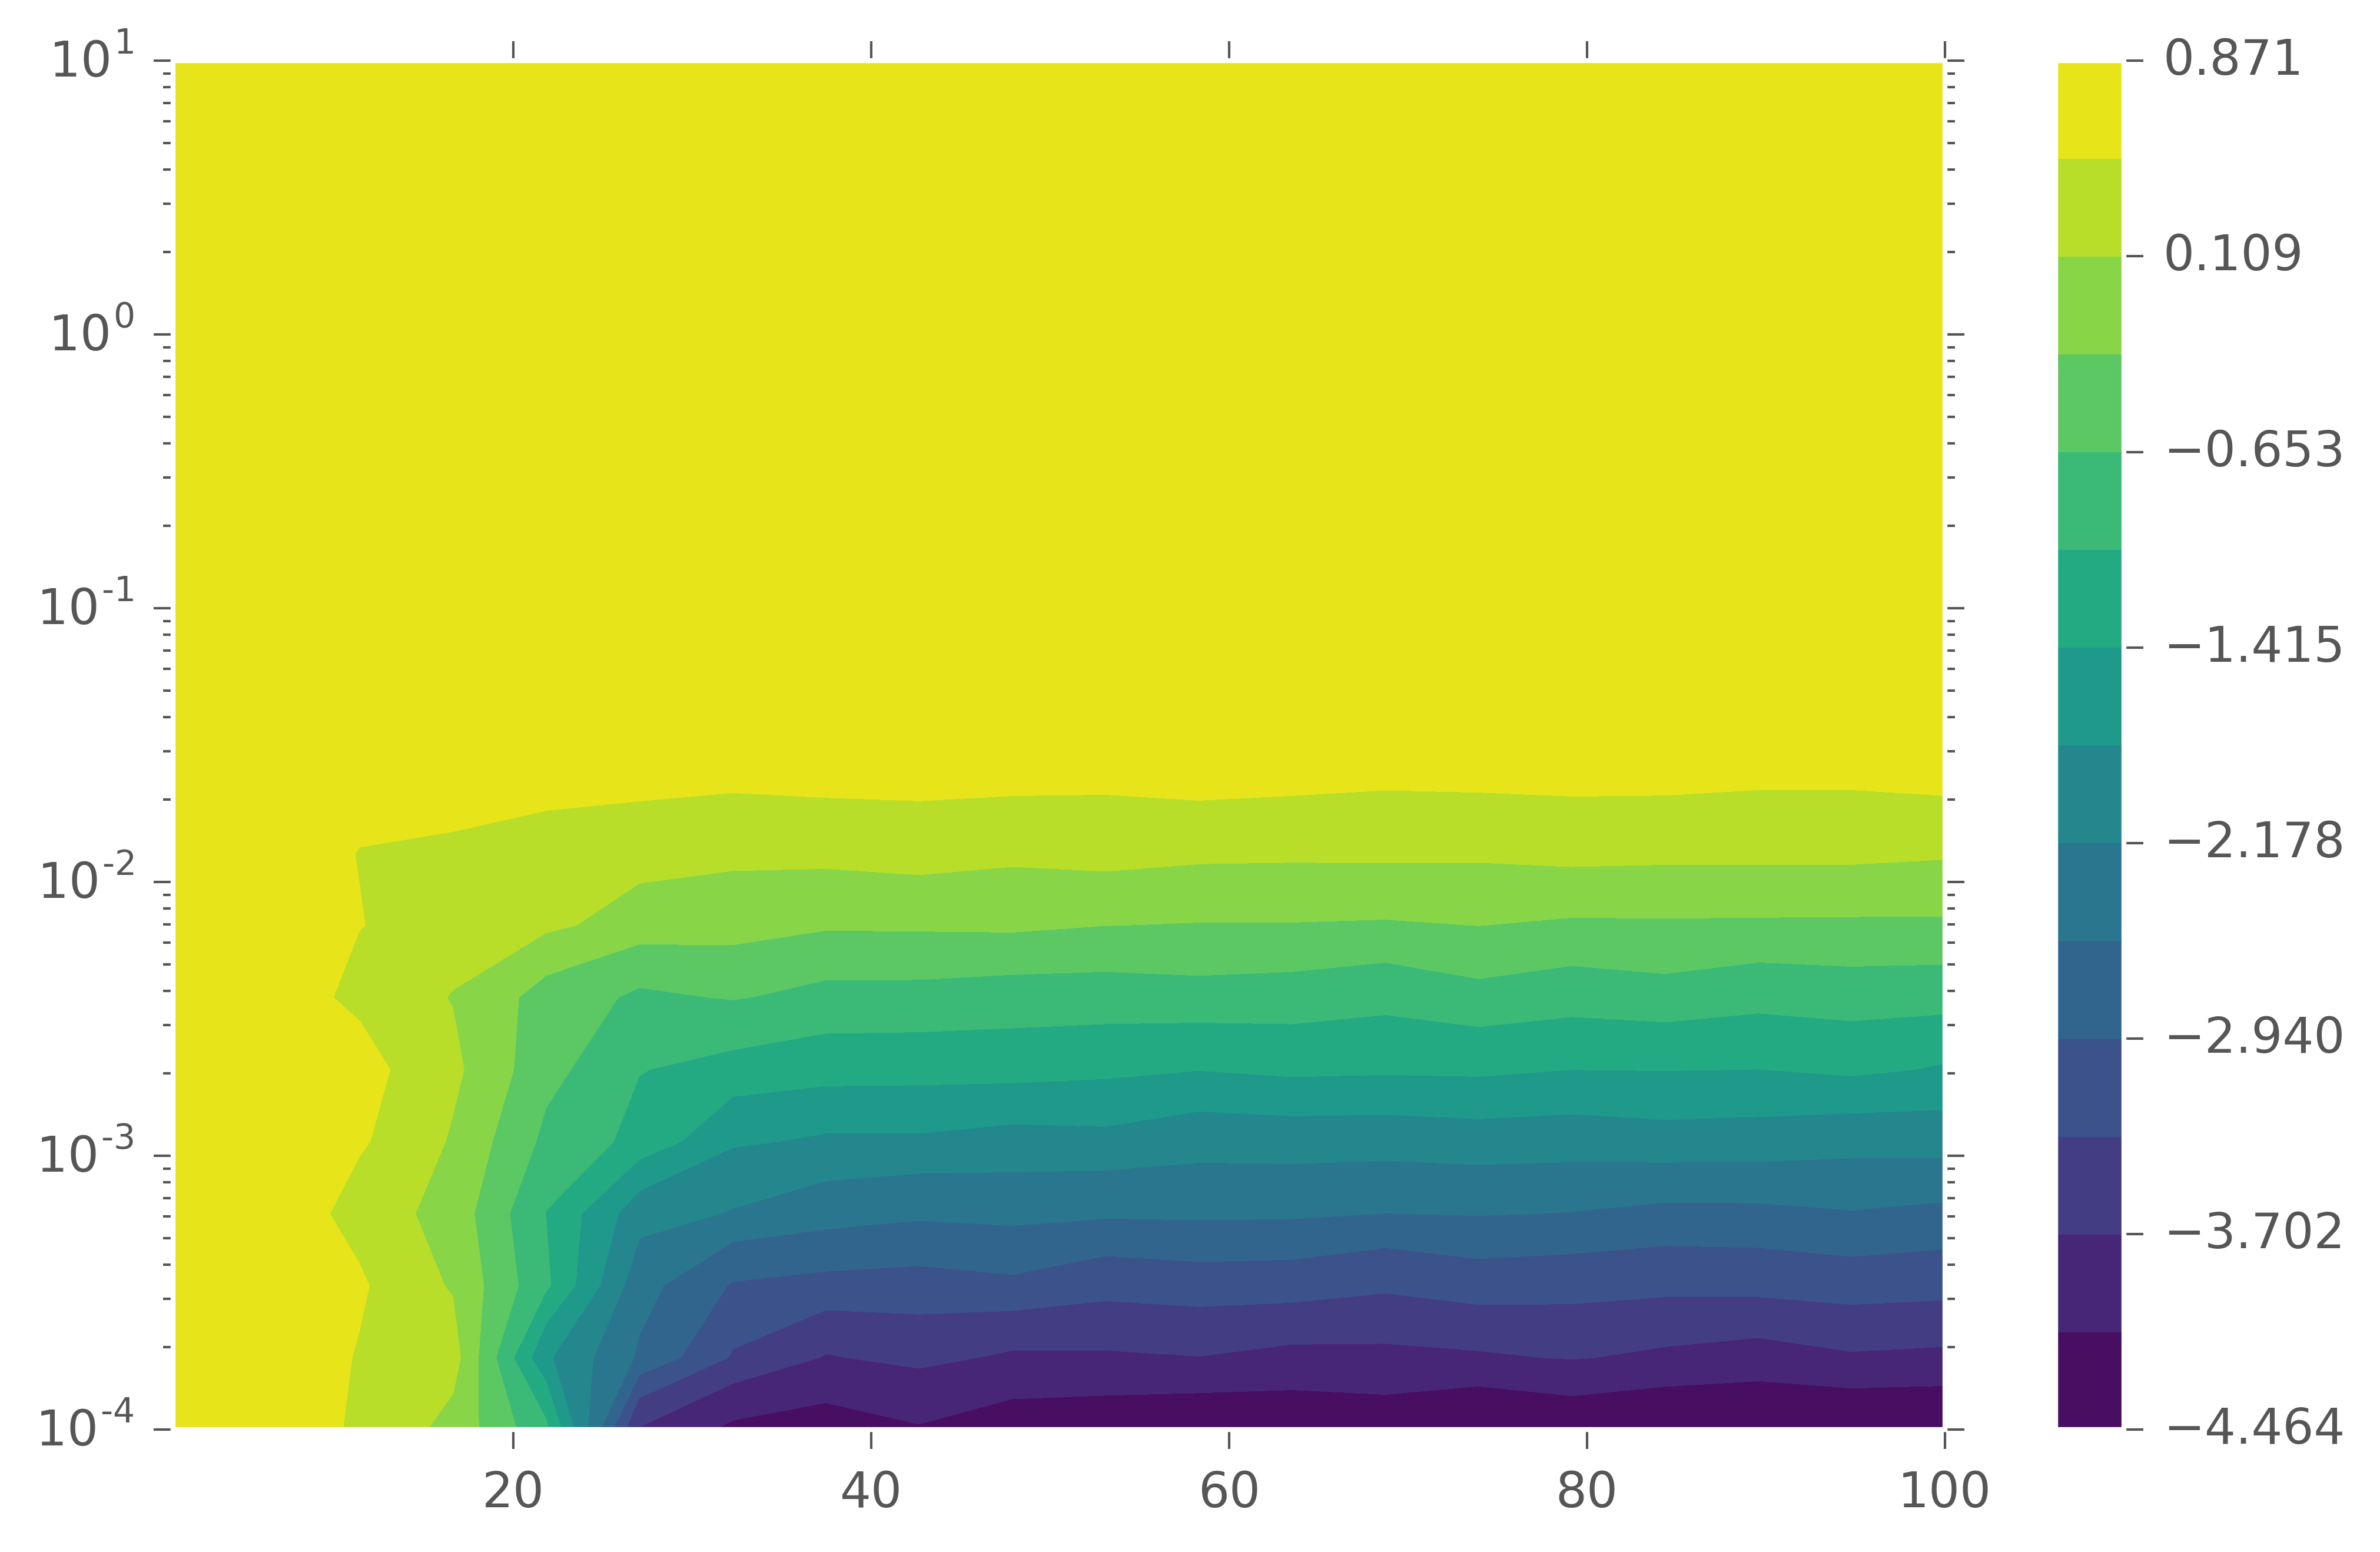

In [6]:
DIM = 100
NNZ = 5
SAMPLES = 20
MAX_MEASUREMENTS = 100
SIGMA = 0

signal = random_sparse_vector(DIM, NNZ)
ms, etas = np.meshgrid(np.linspace(1, MAX_MEASUREMENTS, 20), np.logspace(-4, 1, 20))

errors = [check(random_sparse_vector(DIM, NNZ), SIGMA)(ms, etas) 
          for i in Progress(range(SAMPLES))]
errors = np.mean(errors, axis=0).reshape(ms.shape).astype('float64')

value = np.log(errors)
levels = np.linspace(np.min(value), np.max(value), 15)

pl.yscale('log')
pl.contourf(ms, etas, value, levels=levels)
pl.xlabel = r"m"
pl.ylabel = r"$\lambda$"
pl.colorbar()

As we can see from the figure above, about 25 measurements are enough to recover the signal with high precision.
Since we have perfect measurements (no noise) we obtain better results for a smaller regularization parameter $\eta$.
This changes as soon we add noise to our measurements:

100% (20 of 20) |#########################| Elapsed Time: 0:02:21 Time: 0:02:21


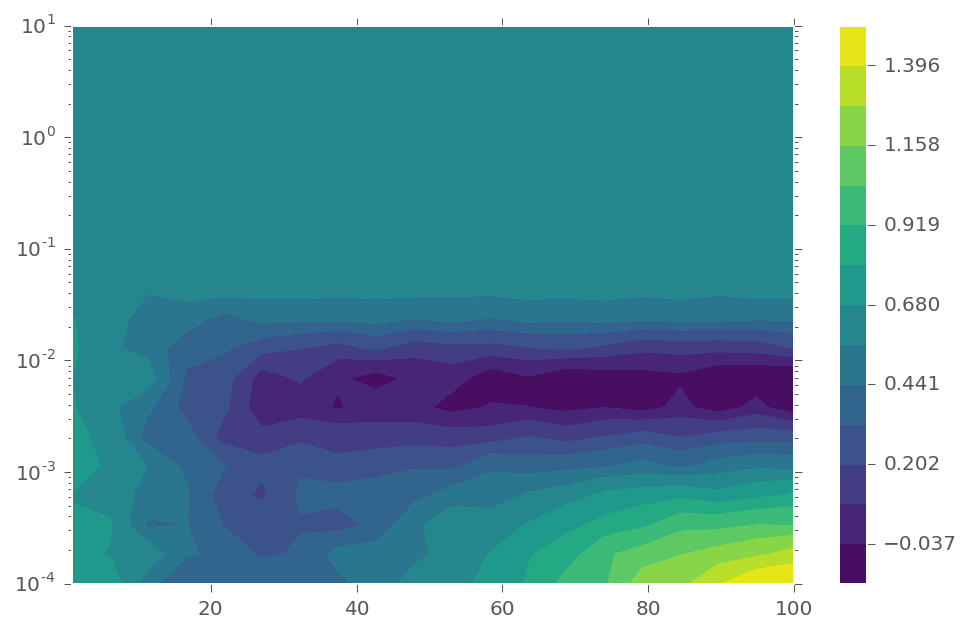

In [130]:
DIM = 100
NNZ = 5
SAMPLES = 20
MAX_MEASUREMENTS = 100
SIGMA = .2

signal = random_sparse_vector(N, NNZ)
ms, etas = np.meshgrid(np.linspace(1, MAX_MEASUREMENTS, 20), np.logspace(-4, 1, 20))

errors = [check(random_sparse_vector(N, NNZ), SIGMA)(ms, etas) 
          for i in Progress(range(SAMPLES))]
errors = np.mean(errors, axis=0).reshape(ms.shape).astype('float64')

value = np.log(errors)
levels = np.linspace(np.min(value), np.max(value), 15)

pl.yscale('log')
pl.contourf(ms, etas, value, levels=levels)
pl.xlabel = r"m"
pl.ylabel = r"$\lambda$"
pl.colorbar()

Here, $\eta \approx 10^{-2}$ gives the best results.
For a larger value the signal is too sparse to fit the data well.
On the other hand, for smaller values we overfit the data to the noisy measurements.

In the following we will use noiseless measurements.

## Constant IHT

First of all we will try _iterative hard thresholding_ (IHT) with a constant stepsize $\mu = 1$.
In this case it can be proven that the algorithm converges provided $\Vert A \Vert_2 < 1$ [1].
Note that a rescaling of the design matrix $A$ can be compensated by rescaling the step size [2].
Due to our choice of normalization for $A$, we have that $\mu = 0.5$ will suffice with high probability.

Since we cannot expect that cIHT is as efficient w.r.t. the sample size as the basis pursuit denoising, we increase the number of measurements.

In [12]:
import sys
sys.path.append('/Users/dsuess/Code/CS\ Algorithms/')

from csalgs.cs import iht
%autoreload 2

In [134]:
def cIHT(x, m, r, stepsize=1.0, rgen=np.random, sensingmat=None, x_init=None):
    A = sensingmat_gauss(m, len(x)) if sensingmat is None else sensingmat
    y = np.dot(A, x)
    x_hat = np.zeros(x.shape) if x_init is None else x_init
    while True:
        x_hat += stepsize * A.T.dot(y - A.dot(x_hat))
        compress(x_hat, r)
        yield x_hat

In [18]:
%debug

> /Users/dsuess/Code/CS Algorithms/csalgs/cs/iht.py(59)accepting_threshold()
     57     def accepting_threshold(x_new, x_old, A):
     58         diff = x_new - x_old
---> 59         assert 1e50 > norm(diff) > 1e-10
     60         return (1 - rescale_const) * norm(diff)**2 / norm(A @ diff)**2
     61 

ipdb> u
> /Users/dsuess/Code/CS Algorithms/csalgs/cs/iht.py(68)stepsize()
     66         while True:
     67             x_new, supp_new = _hard_threshold(x + mu * g, nnz, retsupp=True)
---> 68             omega = accepting_threshold(x_new, x, A)
     69             if _same_supports(supp, supp_new) or (mu < omega):
     70                 return mu

ipdb> p x_new
array([  5.35184934e+49,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -7.18004842e+49,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+

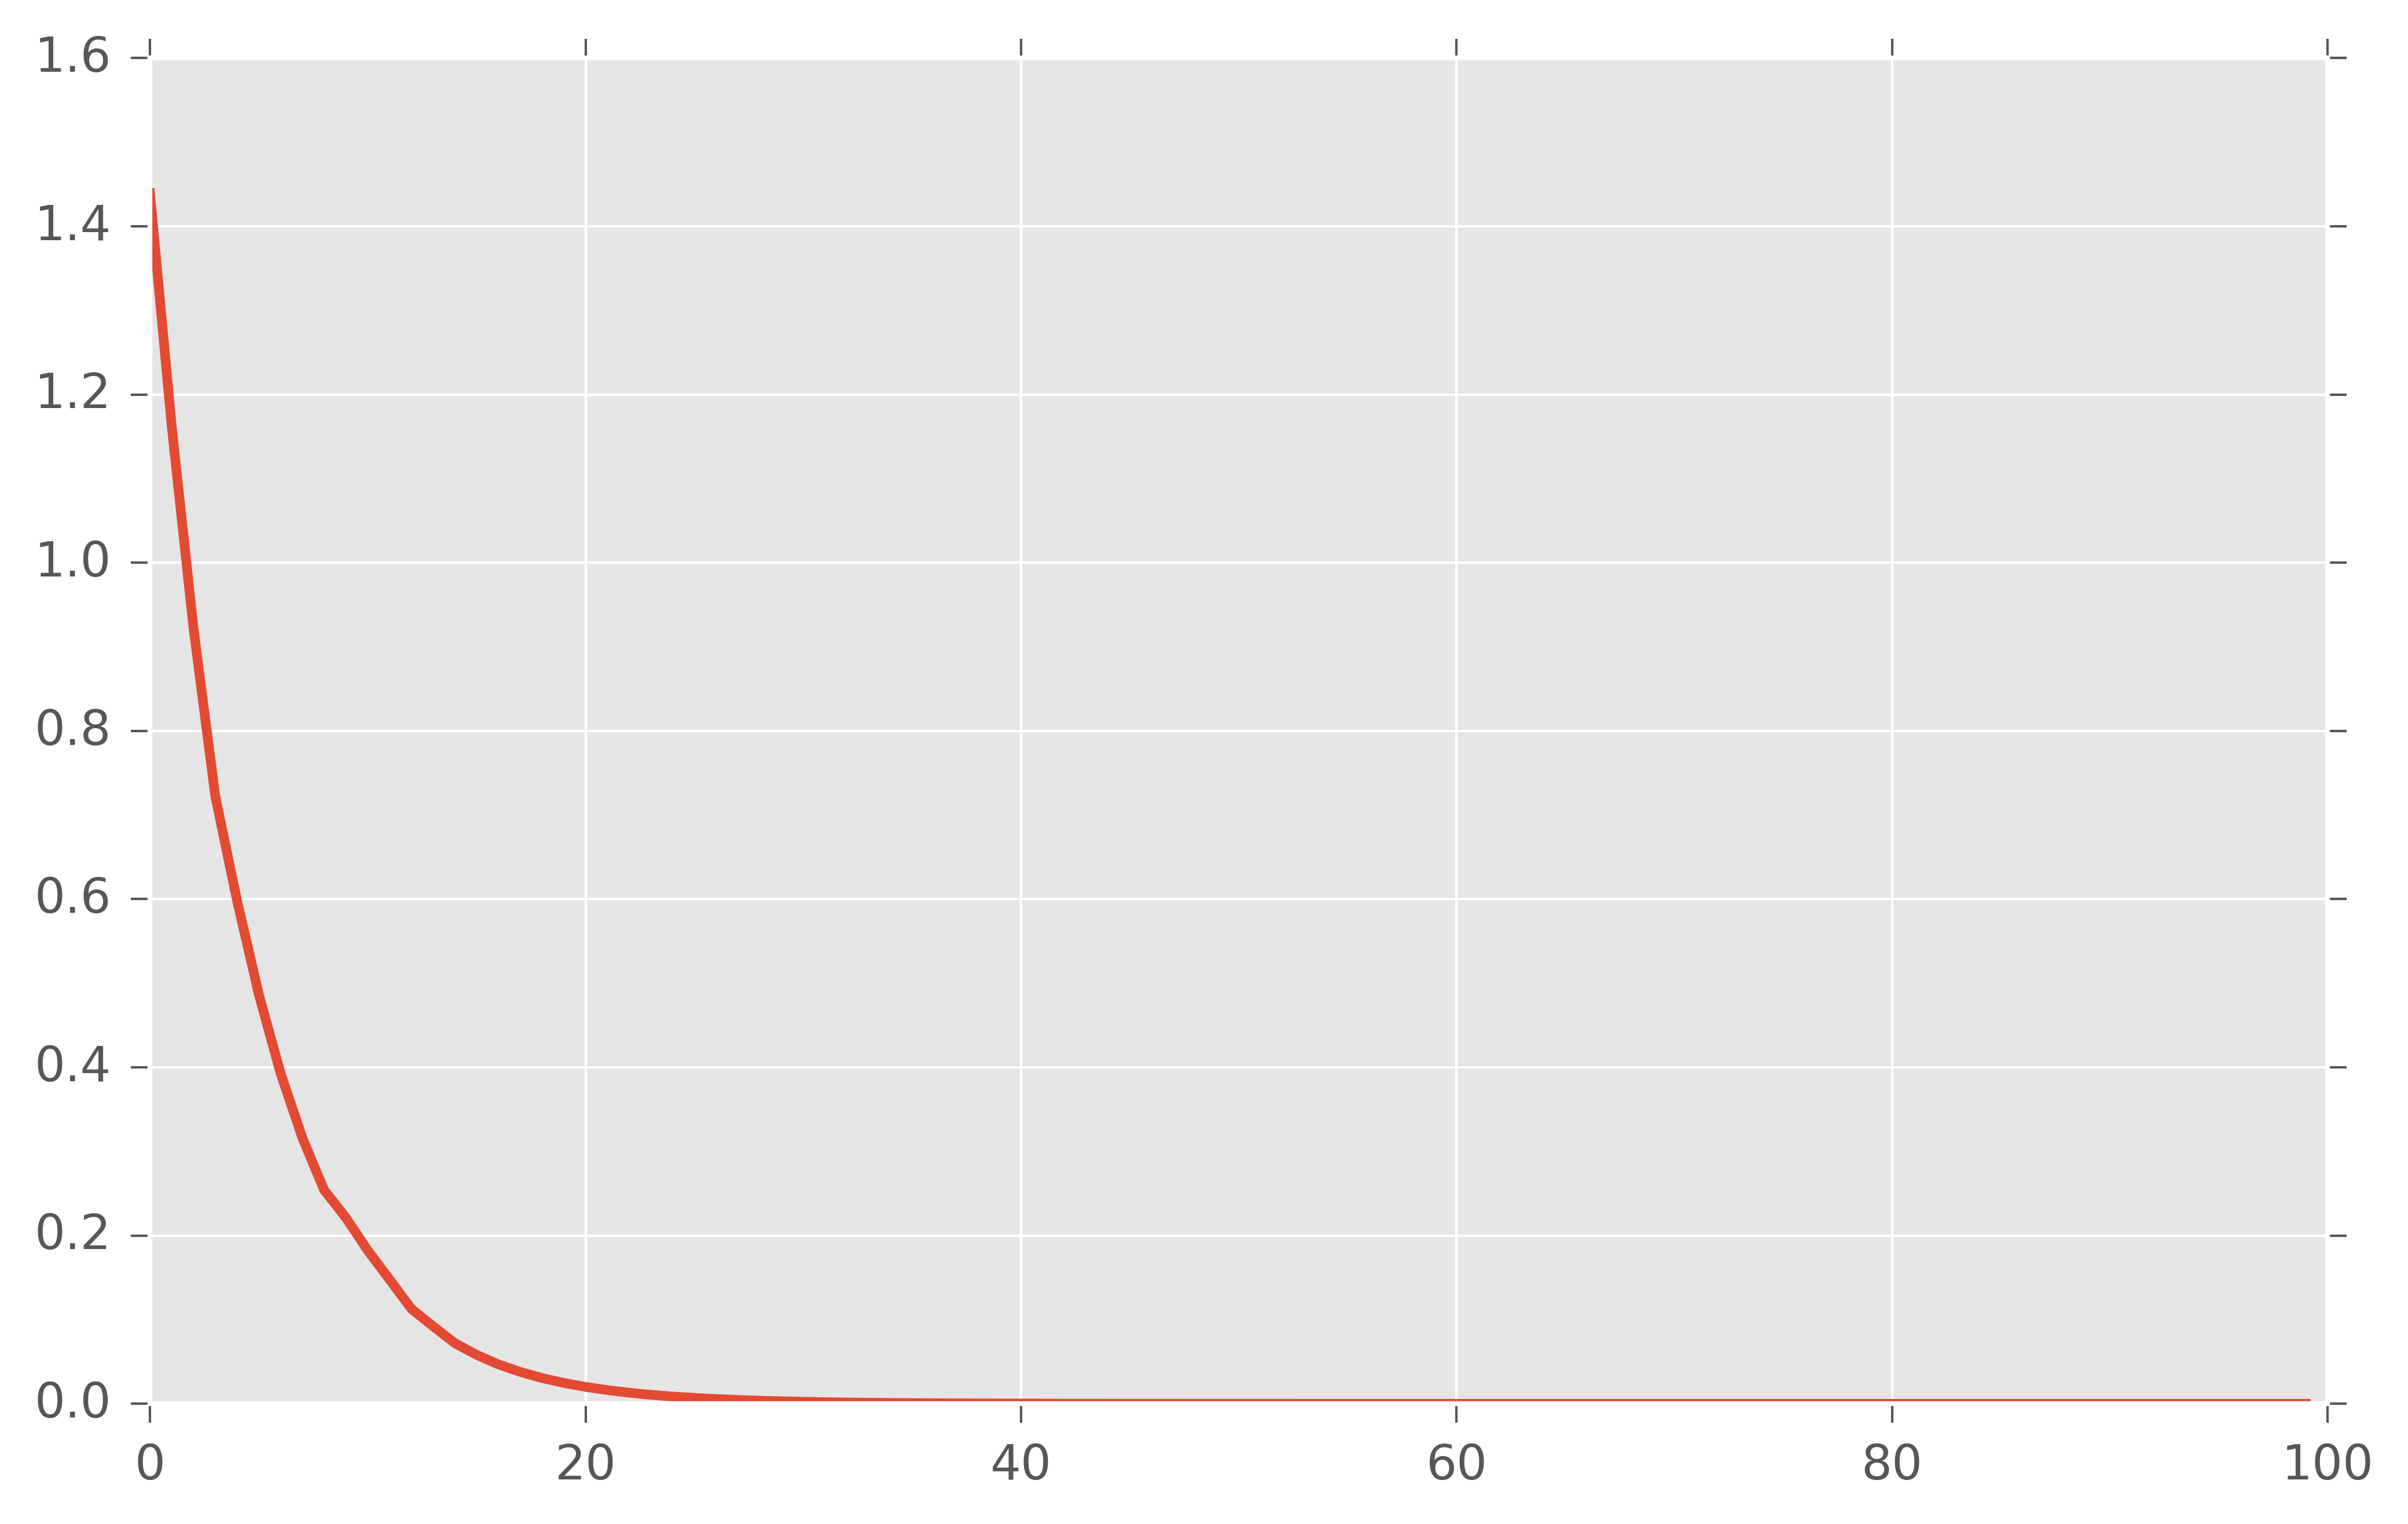

In [ ]:
MEASUREMENTS = 50

for _ in Progress(range(1)):
    A = sensingmat_gauss(MEASUREMENTS, len(signal))
    y = A @ signal
    solution = iht.csIHT(A, y, 2 * NNZ, stepsize=iht.adaptive_stepsize())
    pl.plot([np.linalg.norm(signal - x_hat) for x_hat in it.islice(solution, 100)])
    
pl.xlabel = "\# iterations"
pl.ylabel = r"\Vert x - \hat x \Vert_2"

Note that the cIHT algorithm does not converge reliably even for a large number of iterations.
Even worse, the algorithm gets trapped for a finite amount of time.
This behavior is not good if one wants to check convergence by comparing two consecutive iteration steps.

## Adaptive IHT

In [202]:
SCALE_CONST = .5
KAPPA = 3.


assert KAPPA > 1 / (1 - SCALE_CONST)

def get_stepsize(A, g, supp):
    return norm(g[supp])**2 / norm(np.dot(A[:, supp], g[supp]))**2

def same_supports(supp1, supp2):
    return np.all(np.sort(supp1) == np.sort(supp2))

def compute_omega(x_np, x_n, A):
    diff = x_np - x_n
    return (1 - SCALE_CONST) * norm(diff)**2 / norm(A.dot(diff))**2

def get_update(A, x, y, supp, r):
    g = A.T.dot(y - A.dot(x))
    mu = norm(g[supp])**2 / norm(np.dot(A[:, supp], g[supp]))**2
    while True:
        x_new, supp_new = compression(x + mu * g, r, retsupp=True)
        if same_supports(supp, supp_new) or (mu < compute_omega(x_new, x, A)):
            return x_new, supp_new
        mu /= KAPPA * SCALE_CONST


def aIHT(x, m, r, rgen=np.random, sensingmat=None, x_init=None):
    A = sensingmat_gauss(m, len(x)) if sensingmat is None else sensingmat
    y = np.dot(A, x)
    
    x_hat = np.zeros(x.shape) if x_init is None else x_init
    _, supp = compression(A.T.dot(y), r, retsupp=True)
    
    while True:
        x_hat, supp = get_update(A, x_hat, y, supp, r)
        yield x_hat

100% (20 of 20) |#########################| Elapsed Time: 0:00:03 Time: 0:00:03


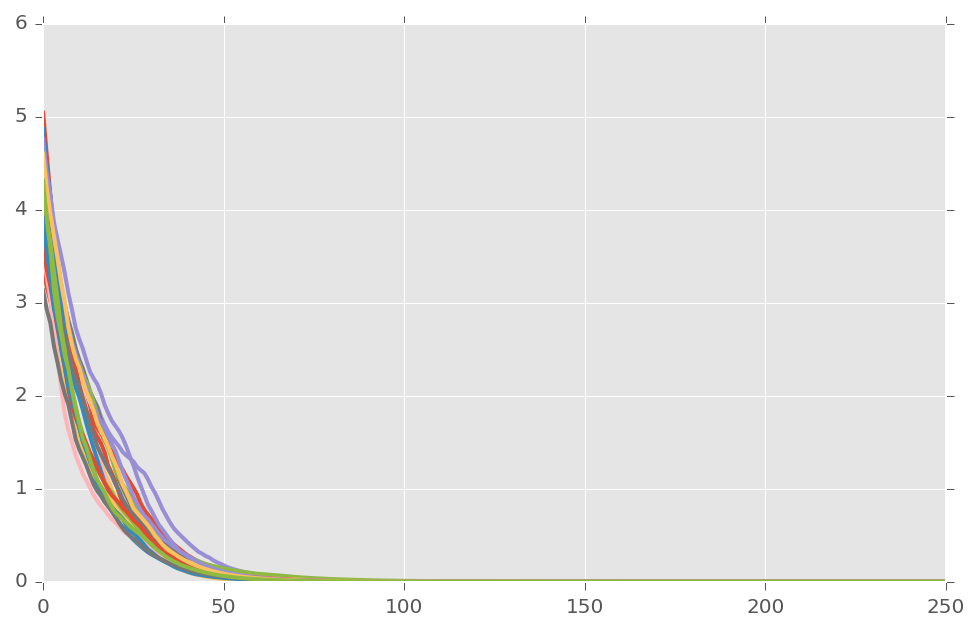

In [203]:
DIM = 1000
NNZ = 25
MEASUREMENTS = 200

for _ in Progress(range(20)):
    signal = random_sparse_vector(DIM, NNZ)
    solution = aIHT(signal, MEASUREMENTS, int(2 * NNZ))
    pl.plot([np.linalg.norm(signal - x_hat) for x_hat in it.islice(solution, 250)])
        
pl.xlabel = "\# iterations"
pl.ylabel = r"\Vert x - \hat x \Vert_2"

Not only does the aIHT algorithm converge much faster than the cIHT, it also does not get trapped as pronounced as the latter.

## References

[1] S. Foucart and H. Rauhut, _A Mathematical Introduction to Compressive Sensing_. New York, NY: Springer New York, 2013.

[2] T. Blumensath and M. E. Davies, _“Normalized Iterative Hard Thresholding: Guaranteed Stability and Performance,”_ IEEE Journal of Selected Topics in Signal Processing, vol. 4, no. 2, pp. 298–309, Apr. 2010.
